Ref:
https://2021.visionsciences.org/?p=A82

# imports

In [1]:
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

from robustness import datasets
from robustness.tools.imagenet_helpers import common_superclass_wnid, ImageNetHierarchy

sys.path.append("../")
from src.image_process.lowpass_filter import GaussianBlurAll
from src.image_process.utils import imshow
from src.dataset.imagenet16 import load_imagenet16

%matplotlib inline

# arguments

In [2]:
out_dir = "./results"
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [3]:
# data settings
batch_size = 32

# random seed settings
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

# main

In [4]:
# load data
# Normalization is set "False" for showing images.
# (It's  set "True" in training or testing)
train_loader, _ = load_imagenet16(batch_size=batch_size, normalization=False)

==> Preparing dataset custom_imagenet..


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


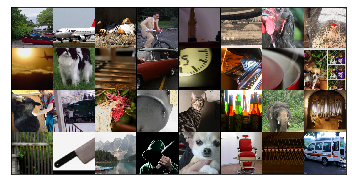

In [5]:
iterator = enumerate(train_loader)
_, (im, lab) = next(iterator)

# show images
imshow(
    torchvision.utils.make_grid(im),
    filename=os.path.join(out_dir, "raw_images.png"),
    scale=False,
)

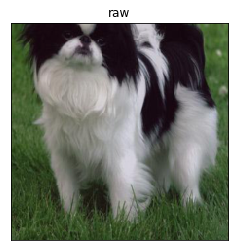

In [6]:
index = 9
img = im[index]
imshow(img, title="raw", filename=os.path.join(out_dir, "raw.png"), scale=False)

In [7]:
img.shape

torch.Size([3, 224, 224])

# devide an image
ref: https://note.nkmk.me/python-skimage-util-view-as-blocks/

In [8]:
import skimage.util

In [9]:
print(224 / 4)
print(224 / 8)
print(224 / 16)
print(224 / 32)

56.0
28.0
14.0
7.0


In [10]:
# no division remainder
print(224 % 4)
print(224 % 8)
print(224 % 16)
print(224 % 32)

0
0
0
0


In [11]:
# Ref: https://github.com/nkmk/python-snippets/blob/5abc15362190047d68a3d917f76a3a61ea1018ce/notebook/numpy_skimage_split_func.py#L10-L15
def split_image_cut(img, div_v, div_h):
    h, w = img.shape[:2]
    block_h, out_h = divmod(h, div_v)
    block_w, out_w = divmod(w, div_h)
    block_shape = (block_h, block_w, 3) if len(img.shape) == 3 else (block_h, block_w)
    return skimage.util.view_as_blocks(img[:h - out_h, :w - out_w], block_shape)

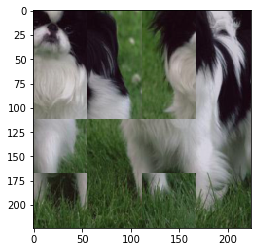

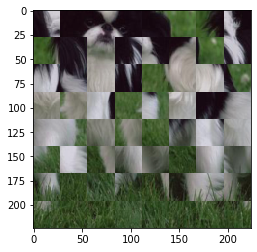

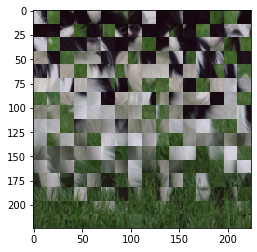

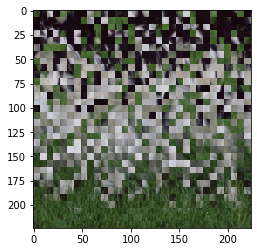

In [12]:
img = im[index]
scales = [4, 8, 16, 32]
for div_v in scales:
    div_h =  div_v
    blocks = split_image_cut(img.numpy().transpose(1, 2, 0), div_v=div_v, div_h=div_h).squeeze()

    for v in range(div_v):
        blocks[v] = blocks[v, np.random.permutation(div_v), ...]

    # "img" and "blocks" have shared memory (unless copy() is used).
    imshow(img=img, filename=os.path.join(out_dir, f"jumbled_{div_v}x{div_h}.png"))